<a href="https://colab.research.google.com/github/WanjohiChristopher/Twitter_Sentiments_analysis/blob/master/Twitter_Sentiments_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.BUSINESS UNDERSTANDING

# Problem Statement

### Detecting the polarity of tweet sentiment

#Context
This is the sentiment140 dataset. It contains 1000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

#description of the data
It contains the following 6 fields:

1.target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

2.ids: The id of the tweet ( 2087)

3.date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

4.flag: The query (lyx). If there is no query, then this value is NO_QUERY.

5.user: the user that tweeted (robotickilldozr)

6.text: the text of the tweet (Lyx is cool)

# Data Understanding

In [ ]:
import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
from google.colab import files
import re
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")                     #Ignoring unnecessory warnings

import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd                                 #for data manipulation and analysis
import nltk                                         #Natural language processing tool-kit

from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer
from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from gensim.models import Word2Vec       

In [1]:
#uploading data to colab enviroment
#upload=files.upload()
#upload

##### importing libraries


In [ ]:
tweet_df=pd.read_csv('tweet.csv')
tweet_df.sample(5)

,target,id,date,flag,user,text
608,4,1467965994,Mon Apr 06 23:01:56 PDT 2009,NO_QUERY,lanaveenker,@AmandaEnglund Sorry to hear about your loss. ...
933,0,1468039856,Mon Apr 06 23:23:51 PDT 2009,NO_QUERY,georgewoods007,Yawn yawn yawn!! 10 more minutes in bed
36,0,1467817225,Mon Apr 06 22:21:27 PDT 2009,NO_QUERY,crosland_12,@cocomix04 ill tell ya the story later not a ...
870,2,1468031172,Mon Apr 06 23:21:02 PDT 2009,NO_QUERY,flashbrother,work again
346,2,1467898511,Mon Apr 06 22:42:56 PDT 2009,NO_QUERY,Day_Zee,@Jeffree_Star Jeffree! How do you keep your ha...


### exploring data more

In [ ]:
#info about data
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  1000 non-null   int64 
 1   id      1000 non-null   int64 
 2   date    1000 non-null   object
 3   flag    1000 non-null   object
 4   user    1000 non-null   object
 5   text    1000 non-null   object
dtypes: int64(2), object(4)
memory usage: 47.0+ KB


In [ ]:
#checking missing values
tweet_df.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [ ]:
#description of the data
tweet_df.describe()

,target,id
count,1000.000000,1.000000e+03
mean,2.078000,1.467936e+09
std,1.323506,7.154601e+04
min,0.000000,1.467810e+09
25%,2.000000,1.467875e+09
50%,2.000000,1.467936e+09
75%,2.000000,1.467998e+09
max,4.000000,1.468056e+09


In [ ]:
#checking taeget value counts
tweet_df['target'].value_counts()

2    561
4    239
0    200
Name: target, dtype: int64

In [ ]:
tweet_df['id'].nunique()

1000

In [ ]:
#checking flag label value counts
tweet_df['flag'].value_counts()

NO_QUERY    1000
Name: flag, dtype: int64

In [ ]:
#checking user label value counts
tweet_df['user'].value_counts()

dreaaa           3
widyatarina      3
atothebed        2
EricaLeigh777    2
AmyJade          2
                ..
alexleebehan     1
TheThreePeas     1
starkissed       1
terrcin          1
theresaxo        1
Name: user, Length: 962, dtype: int64

In [ ]:
# checking dimensions of the data rows and columns
tweet_df.shape

(1000, 6)

### Dropping unwanted columns

we drop -flag since it is only represented as 'no query'whch might not help us -date,user

In [ ]:
tweet_df.drop(columns=['flag','user','date'],inplace=True)

In [ ]:
tweet_df.sample(5)

,target,id,text
500,4,1467936498,@Anistorm Sorry
533,4,1467947104,hates waiting for mails
822,0,1468013866,@kalichosich awww poor puppy is she ok?
701,2,1467986323,Re-pinging @Kyle44: Custom icons I made! =] lo...
383,2,1467909124,Saw an ad on Craigslist for a casting call for...


## Data preparation

In [ ]:
 #regex expression
 #import re

In [ ]:
# group and find the hours and minutes
#tweet_df['text'].str.findall(r'(\d?\d):(\d\d)').sum()

In [ ]:
# extract the entire time, the hours, the minutes, and the period with group names
#tweet_df['text'].str.extractall(r'(?P<time>(?P<hour>\d?\d):(?P<minute>\d\d) ?(?P<period>[ap]m))')

# Data Analysis -Univariate and Bivariate

No handles with labels found to put in legend.


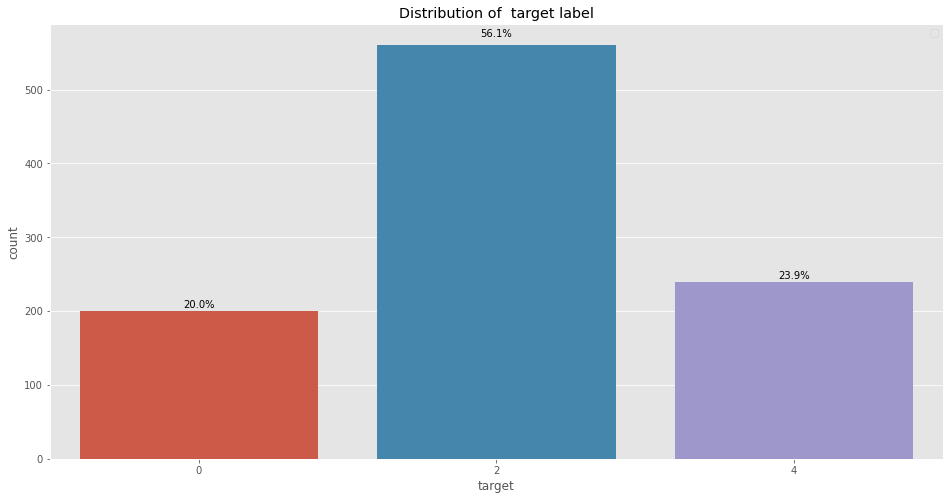

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(16,8))
ax = sns.countplot(x="target", data=tweet_df)
plt.title('Distribution of  target label')
plt.xlabel('target')
plt.legend()
total = len(tweet_df['target'])
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    percentage = f'{100 * p.get_height()/total:.1f}%'
    x, y = p.get_xy() 
    ax.annotate(percentage, (x + width/2, y + height*1.02), ha='center')

From the above analysis of the target variable we can see that neutral tweets were most ,then positive whic accounts for 24% and negative tweets for 20%.

#   PREPROCESSING

## A. Cleaning of Raw Data
This phase involves the deletion of words or characters that do not add value to the meaning of the text. Some of the standard cleaning steps are below:

    Lowering case
    Removal of mentions
    Removal of special characters
    Removal of stopwords ##Stopwords are the words in any language which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For some search engines, these are some of the most common, short function words, such as the, is, at, which, and on
    Removal of hyperlinks
    Removal of numbers
    Removal of whitespaces

In [ ]:
#overview
tweet_df['text'].iloc[:10]

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
5                        @Kwesidei not the whole crew 
6                                          Need a hug 
7    @LOLTrish hey  long time no see! Yes.. Rains a...
8                 @Tatiana_K nope they didn't have it 
9                            @twittera que me muera ? 
Name: text, dtype: object

Lowercase letters

In [ ]:
tweet_df['text']=tweet_df['text'].str.strip().str.lower()
tweet_df['text']


0      @switchfoot http://twitpic.com/2y1zl - awww, t...
1      is upset that he can't update his facebook by ...
2      @kenichan i dived many times for the ball. man...
3         my whole body feels itchy and like its on fire
4      @nationwideclass no, it's not behaving at all....
                             ...                        
995    @dkoenigs thanks man.  i'm so very grateful.  ...
996    @t_wolfe  i miss u too. i'm totally comin back...
997    @sniffinglue ohhh. i love it. ps i'm sad we di...
998             and somehow i still end up in this place
999            @kisluvkis oh that is very sad, poor boy.
Name: text, Length: 1000, dtype: object

Removal of stopwords

In [ ]:
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

tweet_df['text']=tweet_df['text'].apply(lambda x:remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
 tweet_df['text']

0      @switchfoot http://twitpic.com/2y1zl - awww, t...
1      upset can't update facebook texting it... migh...
2      @kenichan dived many times ball. managed save ...
3                       whole body feels itchy like fire
4      @nationwideclass no, behaving all. i'm mad. he...
                             ...                        
995    @dkoenigs thanks man. i'm grateful. feel unwor...
996    @t_wolfe miss u too. i'm totally comin back th...
997      @sniffinglue ohhh. love it. ps i'm sad get hang
998                              somehow still end place
999                         @kisluvkis oh sad, poor boy.
Name: text, Length: 1000, dtype: object

Removal of URLs

In [ ]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
tweet_df['text']=tweet_df['text'].apply(lambda text:remove_urls(text))


In [ ]:
tweet_df['text']

0      @switchfoot  - awww, that's bummer. shoulda go...
1      upset can't update facebook texting it... migh...
2      @kenichan dived many times ball. managed save ...
3                       whole body feels itchy like fire
4      @nationwideclass no, behaving all. i'm mad. he...
                             ...                        
995    @dkoenigs thanks man. i'm grateful. feel unwor...
996    @t_wolfe miss u too. i'm totally comin back th...
997      @sniffinglue ohhh. love it. ps i'm sad get hang
998                              somehow still end place
999                         @kisluvkis oh sad, poor boy.
Name: text, Length: 1000, dtype: object

Removing frequent words but TFDIF Might take care of all these

In [ ]:
#checking and counting frequent words
from collections import Counter
cnt = Counter()
for text in tweet_df["text"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[("i'm", 103),
 ('get', 61),
 ('like', 50),
 ('still', 42),
 ('sad', 40),
 ('go', 38),
 ('time', 38),
 ('really', 38),
 ('going', 38),
 ('-', 37)]

In [ ]:
#removing frequent words
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

tweet_df["text"] = tweet_df["text"].apply(lambda text: remove_freqwords(text))
tweet_df["text"]

0      @switchfoot awww, that's bummer. shoulda got d...
1      upset can't update facebook texting it... migh...
2      @kenichan dived many times ball. managed save ...
3                            whole body feels itchy fire
4      @nationwideclass no, behaving all. mad. here? ...
                             ...                        
995    @dkoenigs thanks man. grateful. feel unworthy ...
996    @t_wolfe miss u too. totally comin back tho! l...
997                  @sniffinglue ohhh. love it. ps hang
998                                    somehow end place
999                         @kisluvkis oh sad, poor boy.
Name: text, Length: 1000, dtype: object

#Removal of Rare words-
This is very intuitive, as some of the words that are very unique in nature like names, brands, product names, and some of the noise characters, such as html leftouts, also need to be removed for different NLP tasks. For example, it would be really bad to use names as a predictor for a text classification problem, even if they come out as a significant predictor. We will talk about this further in subsequent chapters. We definitely don't want all these noisy tokens to be present. We also use length of the words as a criteria for removing words with very a short length or a very long length:

In [ ]:
n_rare_words = 50
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

tweet_df["text"] = tweet_df["text"].apply(lambda text: remove_rarewords(text))

In [ ]:
tweet_df["text"]

0      @switchfoot awww, that's bummer. shoulda got d...
1      upset can't update facebook texting it... migh...
2      @kenichan dived many times ball. managed save ...
3                            whole body feels itchy fire
4      @nationwideclass no, behaving all. mad. here? ...
                             ...                        
995                                  thanks feel though,
996                   miss u too. totally back tho! much
997                                        love it. hang
998                                            end place
999                                         oh sad, poor
Name: text, Length: 1000, dtype: object

Removal of numbers

In [ ]:
def remove_numbers(text):
    # define the pattern to keep
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

tweet_df["text"] = tweet_df["text"].apply(lambda a:remove_numbers(a) )

In [ ]:
!pip install unicodedata2

#Removal of non_ascii


In [ ]:
'''
import unicodedata2
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata2.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
tweet_df["text"] = tweet_df["text"].apply(lambda w:remove_non_ascii(w) )
'''

'\nimport unicodedata2\ndef remove_non_ascii(words):\n    """Remove non-ASCII characters from list of tokenized words"""\n    new_words = []\n    for word in words:\n        new_word = unicodedata2.normalize(\'NFKD\', word).encode(\'ascii\', \'ignore\').decode(\'utf-8\', \'ignore\')\n        new_words.append(new_word)\n    return new_words\ntweet_df["text"] = tweet_df["text"].apply(lambda w:remove_non_ascii(w) )\n'

In [ ]:
tweet_df["text"].sample(5)

900    far  veiws sites put together, checking update...
99     bad nite favorite teams: astros spartans lose....
143    intending finish editing page novel manuscript...
309                                          chiefdelphi
262                   help forget th april amp; th july!
Name: text, dtype: object

Spelling correction

In [ ]:
!pip install pyspellchecker

In [ ]:
'''
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        


tweet_df["text"] = tweet_df["text"].apply(lambda b:correct_spellings(b))
tweet_df["text"].sample(5)
'''

'\nfrom spellchecker import SpellChecker\n\nspell = SpellChecker()\ndef correct_spellings(text):\n    corrected_text = []\n    misspelled_words = spell.unknown(text.split())\n    for word in text.split():\n        if word in misspelled_words:\n            corrected_text.append(spell.correction(word))\n        else:\n            corrected_text.append(word)\n    return " ".join(corrected_text)\n        \n\n\ntweet_df["text"] = tweet_df["text"].apply(lambda b:correct_spellings(b))\ntweet_df["text"].sample(5)\n'

https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/

In [ ]:
#Let's practice spelling and word harmonization
from textblob import TextBlob
tweet_df['text']=tweet_df['text'].apply(lambda x: str(TextBlob(x).correct()))

In [ ]:
tweet_df["text"].sample(5)

79     wonders someone u much make unhappy split seco...
2      kenichan dived many times ball. managed save  ...
586              daniel english professor would ashamed.
269                                 aaaaand nausea back.
882    worked heart today, doubling weight station. r...
Name: text, dtype: object

#Tokenization¶
Tokenization is the process of splitting text into smaller chunks, called tokens. Each token is an input to the machine learning algorithm as a feature. NLTK (Natural Language Toolkit) provides a utility function for tokenizing data.

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
tweet_df['text'] = tweet_df['text'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
tweet_df["text"].sample(5)

740                [stephenkruiser, sorry, hear, dog, .]
209           [twist, think, want, read, books, library]
783    [heidimontag, wish, would, rest, world, ., unf...
540    [lymph, nodes, massive, ram, manual, 's, balls...
116       [hibanick, yeah, a, know, went, stand, chance]
Name: text, dtype: object

# Stemming¶
Stemming is the process of removing and replacing suffixes from a token to obtain the root or base form of the word. This is called a ‘stem’. For example, the stem for the words, ‘satisfied’, ‘satisfaction’, and ‘satisfying’ is ‘satisfy’ and all of these imply the same feeling.

Porter stemmer is a widely used stemming technique. nltk.stem provides the utility function to stem ‘PorterStemmer’

In [ ]:
'''
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

tweet_df["text"] = tweet_df["text"].apply(lambda text: stem_words(text))
'''

'\nfrom nltk.stem.porter import PorterStemmer\n\nstemmer = PorterStemmer()\ndef stem_words(text):\n    return " ".join([stemmer.stem(word) for word in text.split()])\n\ntweet_df["text"] = tweet_df["text"].apply(lambda text: stem_words(text))\n'

#Lemmatization
Lemmatization is similar to stemming in reducing inflected words to their word stem but differs in the way that it makes sure the root word (also called as lemma) belongs to the language.

As a result, this one is generally slower than stemming process. So depending on the speed requirement, we can choose to use either stemming or lemmatization.

Let us use the WordNetLemmatizer in nltk to lemmatize our sentences


One major difference with stemming is that lemmatize takes a part of speech parameter, “pos” If not supplied, the default is “noun.”

In [ ]:

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
#instantiate initializer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
  # v for verb and a for noun
  lem=[lemmatizer.lemmatize(i,pos='v') for i in text]
  return lem

tweet_df['text']=tweet_df['text'].apply(lambda y:lemmatize_words(y))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
tweet_df["text"].sample(5)

994                                              [happy]
311     [play, game, home, !, new, boss, call, yet, ...]
565                              [in, soon, cold, right]
438              [it, 'll, take, days, sister, passport]
79     [wonder, someone, u, much, make, unhappy, spli...
Name: text, dtype: object

#Removing of punctuations
Punctuation removal might be a good step, when punctuation does not brings additional value for text vectorization. Punctuation removal is better to be done after the tokenization step, doing it before might cause undesirable effects. Good choice for TF-IDF, Count, Binary vectorization.

In [ ]:
def remove_punctuation(text):
    no_punct=" ".join([c for c in text if c not in string.punctuation])
    return no_punct
tweet_df['text']=tweet_df['text'].apply(lambda x: remove_punctuation(x))
tweet_df["text"].sample(5)

224    miss twitter phone break use stupid nikita pho...
291                                      afraid bad code
693                    d_castillo ugh that 's disconcert
333                                  michigan state make
103                                 watch quit housequot
Name: text, dtype: object

Removal of whitespace

In [ ]:
def remove_whitespace(word):
    result = word.strip()
    return result
tweet_df["text"] = tweet_df["text"].apply(lambda te: remove_whitespace(te))
tweet_df["text"].sample(5)

196                                                 want
902       org hill love money www think beck buckwild go
744                         stephenkruiser www sad sorry
572                               struggle hard inventor
275    treat nearly day post webster tonight hopefull...
Name: text, dtype: object

## Word Embedding
Word2Vec

In [ ]:
'''
import gensim


   
#custom data is fed to machine for further processing
tweet_df['text']=gensim.models.Word2Vec(tweet_df['text'], min_count = 1, size = 100, window = 5) 

tweet_df['text']
'''

"\nimport gensim\n\n\n   \n#custom data is fed to machine for further processing\ntweet_df['text']=gensim.models.Word2Vec(tweet_df['text'], min_count = 1, size = 100, window = 5) \n\ntweet_df['text']\n"

##defining target variable and  predictor

In [ ]:
X=tweet_df['text']
y=tweet_df['target']

###Extracting Features from Cleaned Tweets

In [ ]:
'''
Now at this stage we need to apply TfidfVectorizer to make the sparse matrix to X
using TF-DiF model
'''
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
VecModel = TfidfVectorizer()
X = VecModel.fit_transform(X)
X

<1000x2449 sparse matrix of type '<class 'numpy.float64'>'
	with 7092 stored elements in Compressed Sparse Row format>

#Modelling

In [ ]:
from sklearn.model_selection import train_test_split
#Now we split the dataset into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=402)

In [ ]:
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (750, 2449)
X_test shape is  (250, 2449)
y_train shape is  (750,)
y_test shape is  (250,)


#Applying Classification Machine Learning ModelS

In [ ]:
#importing classfication algorithms to be applied
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import  MultinomialNB

#####Logistic

In [ ]:
Log=LogisticRegression(solver='saga', random_state=5,max_iter=500,n_jobs=-1)
Log.fit(X_train,y_train)
pred=Log.predict(X_test)


In [ ]:
# model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(pred, y_test))
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

0.524
[[  0  44   1]
 [  2 130   2]
 [  2  68   1]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           2       0.54      0.97      0.69       134
           4       0.25      0.01      0.03        71

    accuracy                           0.52       250
   macro avg       0.26      0.33      0.24       250
weighted avg       0.36      0.52      0.38       250



#other models

In [ ]:
# importing our machine learning algorithms  
from sklearn.tree import DecisionTreeClassifier    
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# instantiating our algorithms
decision_classifier = DecisionTreeClassifier()
random_forest_classifier = RandomForestClassifier()
gbm_classifier = GradientBoostingClassifier()

# training our models
decision_classifier.fit(X_train, y_train)
random_forest_classifier.fit(X_train, y_train)
gbm_classifier.fit(X_train, y_train)

# making predictions
decision_y_prediction = decision_classifier.predict(X_test) 
random_forest_y_pred = random_forest_classifier.predict(X_test)
gbm_y_pred = gbm_classifier.predict(X_test)

# evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
print('Decision Tree')
print(accuracy_score(decision_y_prediction, y_test))
print(confusion_matrix(decision_y_prediction, y_test))
print(classification_report(decision_y_prediction, y_test))


print('Random Forest')
print(accuracy_score(random_forest_y_pred, y_test))
print(confusion_matrix(random_forest_y_pred, y_test))
print(classification_report(random_forest_y_pred, y_test))


print('Gradient Boosting')
print(accuracy_score(gbm_y_pred, y_test))
print(confusion_matrix(gbm_y_pred, y_test))
print(classification_report(gbm_y_pred, y_test))


Decision Tree
0.456
[[ 8 24 11]
 [29 91 45]
 [ 8 19 15]]
              precision    recall  f1-score   support

           0       0.18      0.19      0.18        43
           2       0.68      0.55      0.61       165
           4       0.21      0.36      0.27        42

    accuracy                           0.46       250
   macro avg       0.36      0.36      0.35       250
weighted avg       0.51      0.46      0.48       250

Random Forest
0.512
[[  2   5   5]
 [ 39 125  65]
 [  4   4   1]]
              precision    recall  f1-score   support

           0       0.04      0.17      0.07        12
           2       0.93      0.55      0.69       229
           4       0.01      0.11      0.03         9

    accuracy                           0.51       250
   macro avg       0.33      0.27      0.26       250
weighted avg       0.86      0.51      0.64       250

Gradient Boosting
0.508
[[  3   7   5]
 [ 37 118  60]
 [  5   9   6]]
              precision    recall  f1-score  